# BƯỚC 1: TÌM NEAR-OPTIMAL PATHS (Nearest Shortest Paths)

In [38]:
import heapq
import time
import copy
from collections import defaultdict
import pulp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ======== BƯỚC 1: TÌM ĐƯỜNG ĐI CHO CÁC CẶP OD BẰNG NEAR-OPTIMAL PATHS ========

def build_expanded_graph(n_physical, edges):
    """Xây dựng đồ thị mở rộng với virtual nodes"""
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))  # Road to Road
            G_exp[(u, 1)].append(((v, 2), length))  # Road to Water
        elif mode == 2:  # Water
            G_exp[(u, 2)].append(((v, 2), length))  # Water to Water
            G_exp[(u, 2)].append(((v, 1), length))  # Water to Road
    return G_exp, n_physical

def dijkstra_multi_target(G_exp, targets):
    """Thuật toán Dijkstra với multiple targets"""
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for target in targets:
        dist[target] = 0
        heapq.heappush(heap, (0, target))
    while heap:
        d, node = heapq.heappop(heap)
        if d != dist[node]:
            continue
        for neighbor, length in G_exp.get(node, []):
            new_dist = d + length
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                heapq.heappush(heap, (new_dist, neighbor))
    return dist

def find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000000, max_time=60):
    """Tìm tất cả các đường đi sử dụng DFS"""
    start_time = time.time()
    results = []
    for start_type in [1, 2]:  # Thử cả hai loại phương tiện ban đầu
        visited_physical = [False] * n_physical
        visited_physical[s] = True
        stack = [((s, start_type), 0, [], visited_physical)]
        while stack:
            if time.time() - start_time > max_time or len(results) >= max_paths:
                return results
            node, total_length, path, visited = stack.pop()
            u, _ = node
            if u == t:
                results.append((path + [node], total_length))
                continue
            for next_node, length in G_exp.get(node, []):
                v, _ = next_node
                if not visited[v]:
                    new_path = path + [node]
                    new_length = total_length + length
                    new_visited = visited.copy()
                    new_visited[v] = True
                    stack.append((next_node, new_length, new_path, new_visited))
    return results


# BƯỚC 2: DỮ LIỆU ĐẦU VÀO TỪ TOY EXAMPLE

In [39]:
# ======== BƯỚC 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO ========

def process_input_data():
    """Xử lý và chuẩn bị dữ liệu đầu vào"""
    # Dữ liệu đồ thị vật lý
    n_physical = 5
    edges = [
        (0, 2, 1, 45), (0, 2, 2, 41),
        (0, 3, 1, 23), (0, 3, 2, 96),
        (1, 2, 1, 85),
        (1, 3, 1, 13), (1, 3, 2, 21),
        (1, 4, 1, 74), (1, 4, 2, 87),
        (2, 3, 1, 35), (2, 3, 2, 93),
        (3, 4, 1, 67), (3, 4, 2, 85)
    ]
    
    # Các cặp OD theo loại hàng hóa
    OD_pairs_physical = {
        'g1': [(0, 3), (1, 4)],  # Passenger
        'g2': [(1, 3)]            # Rice
    }
    
    return n_physical, edges, OD_pairs_physical

# BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS (ε = 0.5)

In [40]:

# ======== BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS ========

def find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical):
    """Tìm tất cả các near-optimal paths cho các cặp OD"""
    all_paths_for_model = {}
    
    print("BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS")
    print("=" * 50)
    
    for commodity, od_list in OD_pairs_physical.items():
        for od_pair in od_list:
            s, t = od_pair
            print(f"\nTìm đường từ {s} đến {t} cho commodity {commodity}")
            
            # Tìm tất cả đường đi
            paths = find_all_paths_dfs(G_exp, n_physical, s, t, max_paths=1000, max_time=30)
            
            print(f"  Tìm thấy {len(paths)} đường đi")
            for i, (path, length) in enumerate(paths):
                print(f"  Path {i+1}: {path} - Độ dài: {length}")
            
            all_paths_for_model[(commodity, (s, t))] = paths
    
    return all_paths_for_model

# BƯỚC 4: CHUYỂN PATHS → VIRTUAL ARCS (dùng trong PuLP) và giải mô hình tối ưu 

In [41]:
# ======== BƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU ========

def convert_path_to_model_format(path, length):
    """Chuyển đổi đường đi từ định dạng mở rộng sang định dạng mô hình"""
    arcs = []
    for i in range(len(path) - 1):
        u, u_mode = path[i]
        v, v_mode = path[i + 1]
        
        # Tạo real arc từ u đến virtual node của v
        real_arc = (u, f"{v}^{v_mode}")
        arcs.append(real_arc)
        
        # Nếu không phải là bước cuối, thêm virtual arc
        if i < len(path) - 2:
            virtual_arc = (f"{v}^{v_mode}", v)
            arcs.append(virtual_arc)
    
    # Thêm virtual arc cho đích
    last_node, last_mode = path[-1]
    virtual_arc_dest = (f"{last_node}^{last_mode}", last_node)
    arcs.append(virtual_arc_dest)
    
    return arcs, length

def prepare_optimization_data(all_paths_for_model):
    """Chuẩn bị dữ liệu cho mô hình tối ưu"""
    # Chuyển đổi tất cả paths sang định dạng mô hình
    paths_converted = {}
    for key, path_list in all_paths_for_model.items():
        converted_paths = []
        for path, length in path_list:
            model_path, path_length = convert_path_to_model_format(path, length)
            converted_paths.append((model_path, path_length))
        paths_converted[key] = converted_paths
    
    # Điều chỉnh node từ 0-based sang 1-based
    paths_adjusted = {}
    for (commodity, orig_od), path_list in paths_converted.items():
        orig_s, orig_t = orig_od
        new_od = (orig_s + 1, orig_t + 1)
        paths_adjusted[(commodity, new_od)] = path_list
    
    return paths_adjusted

def create_optimization_model(paths_adjusted):
    """Tạo và giải mô hình tối ưu"""
    # 1. SETUP INPUT DATA
    T = [1, 2]  # Các giai đoạn thời gian
    
    # Định nghĩa nodes
    real_nodes = [1, 2, 3, 4, 5]  # 1-based nodes
    virtual_nodes = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
    all_nodes = real_nodes + virtual_nodes
    
    # Hubs
    H = [3]  # Cần Thơ
    potential_hubs = [3]
    existing_hubs = []
    
    # Thu thập tất cả các arc từ các đường đi đã tìm
    real_arcs = []
    virtual_arcs = []
    
    for path_list in paths_adjusted.values():
        for path, _ in path_list:
            for arc in path:
                if '^' in str(arc[1]):  # Real arc
                    if arc not in real_arcs:
                        real_arcs.append(arc)
                else:  # Virtual arc
                    if arc not in virtual_arcs:
                        virtual_arcs.append(arc)
    
    print(f"\nReal arcs: {real_arcs}")
    print(f"Virtual arcs: {virtual_arcs}")
    
    # All arcs
    A = real_arcs + virtual_arcs
    potential_arcs = [(3, '4^1'), (3, '4^2')]  # Các arc có thể nâng cấp
    existing_arcs = [arc for arc in A if arc not in potential_arcs]
    
    # Commodities
    commodities = {'passenger': 'g1', 'rice': 'g2'}
    
    # Origin-Destination pairs (1-based)
    OD_pairs = {
        'g1': [(1, 4), (2, 5)],  # Passenger
        'g2': [(2, 4)]           # Rice
    }
    
    # Transportation costs on arcs
    arc_costs = {}
    for arc in real_arcs:
        arc_costs[arc] = 1  # Giá mặc định
    for arc in virtual_arcs:
        arc_costs[arc] = 0  # Virtual arcs có cost = 0
    
    # Các tham số khác
    switch_cost = 2
    hub_service_cost = {3: 1}
    hub_upgrade_cost = 1000
    hub_capacity = {0: 2000, 1: 7000}
    
    arc_upgrade_costs = {
        (3, '4^1'): 800,
        (3, '4^2'): 500
    }
    
    arc_capacities = {
        (3, '4^1'): {0: 0, 1: 3000},
        (3, '4^2'): {0: 0, 1: 4000}
    }
    
    existing_hub_capacity = 2000
    existing_arc_capacity = 2000
    
    # Transportation demand
    demands = {
        ('g1', (1, 4)): 3000,  # Passenger từ An Giang -> TP.HCM
        ('g1', (2, 5)): 2800,  # Passenger từ Đồng Tháp -> Vĩnh Long
        ('g2', (2, 4)): 4000   # Rice từ Đồng Tháp -> TP.HCM
    }
    
    # 2. INITIALIZE MODEL AND DECISION VARIABLES
    model = pulp.LpProblem("Multimodal_Transport_Network_Optimization", pulp.LpMinimize)
    
    # Decision variables
    y_hub = pulp.LpVariable.dicts(
        "y_hub", 
        [(h, l, t) for h in potential_hubs for l in [0, 1] for t in T],
        cat='Binary'
    )
    
    y_arc = pulp.LpVariable.dicts(
        "y_arc", 
        [(a[0], a[1], l, t) for a in potential_arcs for l in [0, 1] for t in T],
        cat='Binary'
    )
    
    v_path = {}
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for idx, _ in enumerate(paths_adjusted[(g, od)]):
                for t in T:
                    v_name = f"v_{g}_{od[0]}_{od[1]}_p{idx+1}_t{t}"
                    v_path[(g, od, idx, t)] = pulp.LpVariable(v_name, lowBound=0, upBound=1)
    
    u_hub = pulp.LpVariable.dicts(
        "u_hub", 
        [(h, t) for h in H for t in T],
        lowBound=0
    )
    
    x_arc = pulp.LpVariable.dicts(
        "x_arc", 
        [(a[0], a[1], t) for a in A for t in T],
        lowBound=0
    )
    
    # 3. BUILD OBJECTIVE FUNCTION
    investment_cost = pulp.lpSum(
        [hub_upgrade_cost * hub_capacity[l] * y_hub[(h, l, t)] 
            for h in potential_hubs for l in [0, 1] for t in T] 
        + 
        [arc_upgrade_costs[a] * arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
            for a in potential_arcs for l in [0, 1] for t in T]
    )
    
    service_cost = pulp.lpSum(
        hub_service_cost[h] * u_hub[(h, t)] 
        for h in H for t in T
    )
    
    transport_cost = pulp.lpSum(0)
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            demand = demands[(g, od)]
            for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                # Tính path transport cost
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                
                for arc in path:
                    path_cost += arc_costs[arc]
                    
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                
                path_cost += mode_switches * switch_cost
                
                for t in T:
                    transport_cost += path_cost * demand * v_path[(g, od, idx, t)]
    
    model += investment_cost + service_cost + transport_cost
    
    # 4. CONSTRAINTS
    # Flow allocation constraint
    for g, od_pairs in OD_pairs.items():
        for od in od_pairs:
            for t in T:
                model += pulp.lpSum(v_path[(g, od, idx, t)] for idx in range(len(paths_adjusted[(g, od)]))) == 1
    
    # Calculate flow through hubs
    for h in H:
        for t in T:
            total_flow = 0
            for g, od_pairs in OD_pairs.items():
                for od in od_pairs:
                    demand = demands[(g, od)]
                    for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                        if any(arc[1] == str(h) or arc[1] == h for arc in path):
                            total_flow += demand * v_path[(g, od, idx, t)]
            model += u_hub[(h, t)] == total_flow
    
    # Calculate flow through arcs
    for arc in A:
        for t in T:
            total_flow = 0
            for g, od_pairs in OD_pairs.items():
                for od in od_pairs:
                    demand = demands[(g, od)]
                    for idx, (path, _) in enumerate(paths_adjusted[(g, od)]):
                        if arc in path:
                            total_flow += demand * v_path[(g, od, idx, t)]
            model += x_arc[(arc[0], arc[1], t)] == total_flow
    
    # Hub capacity constraints
    for h in potential_hubs:
        for t in T:
            model += u_hub[(h, t)] <= pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
            )
    
    # Arc capacity constraints
    for a in potential_arcs:
        for t in T:
            model += x_arc[(a[0], a[1], t)] <= pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] 
                for l in [0, 1]
            )
    
    for a in existing_arcs:
        if a in real_arcs:
            for t in T:
                model += x_arc[(a[0], a[1], t)] <= existing_arc_capacity
    
    # Logic constraints
    for h in potential_hubs:
        for t in T:
            model += pulp.lpSum(y_hub[(h, l, t)] for l in [0, 1]) == 1
    
    for a in potential_arcs:
        for t in T:
            model += pulp.lpSum(y_arc[(a[0], a[1], l, t)] for l in [0, 1]) == 1
    
    # Non-decreasing capacity constraints
    for h in potential_hubs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model += pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                hub_capacity[l] * y_hub[(h, l, t)] for l in [0, 1]
            )
    
    for a in potential_arcs:
        for t_idx, t in enumerate(T[:-1]):
            t_next = T[t_idx + 1]
            model += pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t_next)] for l in [0, 1]
            ) >= pulp.lpSum(
                arc_capacities[a][l] * y_arc[(a[0], a[1], l, t)] for l in [0, 1]
            )
    
    return model, {
        'y_hub': y_hub, 'y_arc': y_arc, 'v_path': v_path, 
        'u_hub': u_hub, 'x_arc': x_arc,
        'OD_pairs': OD_pairs, 'paths_adjusted': paths_adjusted,
        'demands': demands, 'commodities': commodities,
        'potential_hubs': potential_hubs, 'potential_arcs': potential_arcs,
        'T': T, 'real_nodes': real_nodes, 'virtual_nodes': virtual_nodes
    }

def solve_and_display_results(model, data):
    """Giải mô hình và hiển thị kết quả"""
    print("\n" + "="*50)
    print("BẮT ĐẦU GIẢI MÔ HÌNH TỐI ƯU")
    print("="*50)
    
    model.solve()
    
    print(f"Trạng thái giải: {pulp.LpStatus[model.status]}")
    print(f"Tổng chi phí tối ưu: {pulp.value(model.objective):.2f}\n")
    
    # Hiển thị kết quả
    def get_province_name(node_id):
        names = {
            1: "An Giang",
            2: "Đồng Tháp", 
            3: "Cần Thơ",
            4: "TP.HCM",
            5: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    
    print("KẾT QUẢ TỐI ƯU:")
    
    # Hiển thị các biến quyết định
    print("\n[1] NÂNG CẤP HUB:")
    for h in data['potential_hubs']:
        for t in data['T']:
            for l in [0, 1]:
                if pulp.value(data['y_hub'][(h, l, t)]) > 0.5:
                    capacity = 2000 if l == 0 else 7000
                    action = "NÂNG CẤP" if l == 1 else "GIỮ NGUYÊN"
                    print(f"  Hub {get_province_name(h)} - Giai đoạn {t}: {action} (công suất: {capacity})")
    
    print("\n[2] NÂNG CẤP ARC:")
    for a in data['potential_arcs']:
        for t in data['T']:
            for l in [0, 1]:
                if pulp.value(data['y_arc'][(a[0], a[1], l, t)]) > 0.5:
                    capacity = 0 if l == 0 else (3000 if '^1' in a[1] else 4000)
                    mode = "ĐƯỜNG BỘ" if '^1' in a[1] else "ĐƯỜNG THỦY"
                    action = "NÂNG CẤP" if l == 1 else "GIỮ NGUYÊN"
                    print(f"  Arc {get_province_name(a[0])}→{a[1].split('^')[0]} ({mode}) - Giai đoạn {t}: {action} (công suất: {capacity})")
    
    print("\n[3] PHÂN BỔ LUỒNG VẬN TẢI:")
    for g_name, g_code in data['commodities'].items():
        print(f"\n  Mặt hàng: {g_name.upper()}")
        for od in data['OD_pairs'][g_code]:
            origin, dest = od
            print(f"    Tuyến: {get_province_name(origin)} → {get_province_name(dest)}")
            for t in data['T']:
                print(f"      Giai đoạn {t}:")
                total_flow = 0
                for idx, (path, _) in enumerate(data['paths_adjusted'][(g_code, od)]):
                    flow_value = pulp.value(data['v_path'][(g_code, od, idx, t)])
                    if flow_value > 0.001:
                        flow_amount = data['demands'][(g_code, od)] * flow_value
                        total_flow += flow_amount
                        path_desc = " → ".join([f"{arc[0]}->{arc[1]}" for arc in path])
                        print(f"        Path {idx+1}: {flow_amount:.2f} đơn vị")
                        print(f"          Route: {path_desc}")
                print(f"        Tổng luồng: {total_flow:.2f}")
    
    print("\n[4] TỔNG HỢP CHI PHÍ:")
    investment_cost = pulp.lpSum(
        [1000 * (2000 if l == 0 else 7000) * data['y_hub'][(h, l, t)] 
            for h in data['potential_hubs'] for l in [0, 1] for t in data['T']] 
        + 
        [({(3, '4^1'): 800, (3, '4^2'): 500}[a] * ({0: 0, 1: 3000} if '^1' in a[1] else {0: 0, 1: 4000})[l] * data['y_arc'][(a[0], a[1], l, t)]) 
            for a in data['potential_arcs'] for l in [0, 1] for t in data['T']]
    )
    
    service_cost = pulp.lpSum(
        1 * data['u_hub'][(h, t)] 
        for h in [3] for t in data['T']
    )
    
    transport_cost = pulp.lpSum(0)
    for g, od_pairs in data['OD_pairs'].items():
        for od in od_pairs:
            demand = data['demands'][(g, od)]
            for idx, (path, _) in enumerate(data['paths_adjusted'][(g, od)]):
                path_cost = 0
                mode_switches = 0
                prev_mode = None
                
                for arc in path:
                    path_cost += (1 if '^' in str(arc[1]) else 0)
                    
                    current_mode = 'road' if str(arc[1]).endswith('^1') else 'water'
                    
                    if prev_mode and prev_mode != current_mode:
                        mode_switches += 1
                    prev_mode = current_mode
                
                path_cost += mode_switches * 2
                
                for t in data['T']:
                    transport_cost += path_cost * demand * data['v_path'][(g, od, idx, t)]
    
    print(f"  Chi phí đầu tư: {pulp.value(investment_cost):.2f}")
    print(f"  Chi phí dịch vụ hub: {pulp.value(service_cost):.2f}") 
    print(f"  Chi phí vận tải: {pulp.value(transport_cost):.2f}")
    print(f"  TỔNG CỘNG: {pulp.value(model.objective):.2f}")
    
    return model


# BƯỚC 5: Visualization

In [42]:
def visualize_network_flows(data, model):
    """Trực quan hóa luồng phân bố cho các loại hàng hóa"""
    
    def get_province_name(node_id):
        names = {
            0: "An Giang",  # Thêm node 0
            1: "An Giang",
            2: "Đồng Tháp", 
            3: "Cần Thơ",
            4: "TP.HCM",
            5: "Vĩnh Long"
        }
        return names.get(node_id, f"Node {node_id}")
    
    # Vẽ biểu đồ cho từng loại hàng hóa
    for commodity_name, commodity_code in data['commodities'].items():
        # Tạo đồ thị mạng lưới cho hàng hóa này
        G = nx.DiGraph()
        
        # Thêm nodes - bao gồm cả node 0-based và 1-based để an toàn
        all_real_nodes = list(range(6))  # 0-5
        for node in all_real_nodes:
            G.add_node(node, label=get_province_name(node), type='real')
        
        virtual_nodes_list = ['3^1', '3^2', '4^1', '4^2', '5^1', '5^2']
        for node in virtual_nodes_list:
            G.add_node(node, label=node, type='virtual')
        
        # Tính toán luồng trên các cung cho hàng hóa này từ biến v_path
        edge_flows = {}
        
        print(f"\nTính toán luồng cho {commodity_name}...")
        
        for od in data['OD_pairs'][commodity_code]:
            print(f"  Xử lý OD: {od}")
            demand = data['demands'][(commodity_code, od)]
            
            for t in data['T']:
                for idx, (path, path_length) in enumerate(data['paths_adjusted'][(commodity_code, od)]):
                    flow_value = pulp.value(data['v_path'][(commodity_code, od, idx, t)])
                    
                    if flow_value is not None and flow_value > 0.001:
                        flow_amount = demand * flow_value
                        
                        # Thêm tất cả các arc trong path
                        for arc in path:
                            # Chuẩn hóa arc - chuyển đổi giữa 0-based và 1-based nếu cần
                            u, v = arc
                            # Nếu u là số và lớn hơn 5, có thể là 1-based, chuyển về 0-based
                            if isinstance(u, int) and u > 5:
                                u = u - 1
                            if isinstance(v, str) and '^' in v:
                                # Virtual node: '3^1' -> 2 (0-based) hoặc giữ nguyên
                                pass
                            elif isinstance(v, int) and v > 5:
                                v = v - 1
                            
                            arc_normalized = (u, v)
                            if arc_normalized not in edge_flows:
                                edge_flows[arc_normalized] = 0
                            edge_flows[arc_normalized] += flow_amount
        
        # Thêm edges và flow values vào đồ thị
        for arc, flow in edge_flows.items():
            u, v = arc
            G.add_edge(u, v, weight=flow)
            print(f"  Arc {u} -> {v}: {flow:.2f}")
        
        # Bỏ qua nếu không có luồng
        if len(G.edges()) == 0:
            print(f"Không có luồng cho mặt hàng {commodity_name}")
            continue
        
        # Tạo figure
        plt.figure(figsize=(14, 10))
        
        # Tạo layout cho nodes - bao gồm cả node 0-based
        pos = {
            # Real nodes - 0-based
            0: (0, 2),    # An Giang - phía Tây
            1: (2, 3),    # Đồng Tháp - phía Bắc  
            2: (4, 2),    # Cần Thơ - trung tâm
            3: (6, 3),    # TP.HCM - phía Đông
            4: (2, 1),    # Vĩnh Long - phía Nam
            
            # Real nodes - 1-based (nếu có)
            5: (2, 1),    # Vĩnh Long (trùng với 4)
            
            # Virtual nodes
            '3^1': (3.5, 2.3),
            '3^2': (4.5, 1.7),
            '4^1': (5.5, 2.8), 
            '4^2': (6.5, 3.2),
            '5^1': (1.8, 1.3),
            '5^2': (2.2, 0.7)
        }
        
        # Đảm bảo tất cả nodes trong G đều có vị trí
        missing_nodes = [node for node in G.nodes() if node not in pos]
        if missing_nodes:
            print(f"⚠️ Các node sau không có trong pos: {missing_nodes}")
            # Thêm vị trí mặc định cho các node thiếu
            for i, node in enumerate(missing_nodes):
                pos[node] = (i * 2, 0)  # Xếp hàng ngang ở dưới
        
        # Chuẩn bị dữ liệu cho visualization
        real_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'real']
        virtual_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'virtual']
        
        edges = list(G.edges())
        
        # Kiểm tra xem có edges không
        if not edges:
            print(f"Không có edges để vẽ cho {commodity_name}")
            continue
            
        edge_widths = []
        edge_colors = []
        
        for u, v in edges:
            flow = G[u][v]['weight']
            edge_widths.append(max(0.5, flow / 500))  # Scale width
            # Màu sắc khác nhau cho road vs water
            if '^1' in str(v):  # Road
                edge_colors.append('red')
            elif '^2' in str(v):  # Water
                edge_colors.append('blue')
            else:  # Virtual arcs hoặc real arcs
                edge_colors.append('green')
        
        try:
            # Vẽ real nodes
            if real_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=real_nodes, 
                                      node_color='lightblue', 
                                      node_size=1000, 
                                      alpha=0.9,
                                      edgecolors='darkblue',
                                      linewidths=2)
            
            # Vẽ virtual nodes
            if virtual_nodes:
                nx.draw_networkx_nodes(G, pos, nodelist=virtual_nodes, 
                                      node_color='lightgreen', 
                                      node_size=600, 
                                      alpha=0.7,
                                      node_shape='s',
                                      edgecolors='darkgreen',
                                      linewidths=1)
            
            # Vẽ edges - QUAN TRỌNG: chỉ vẽ edges có cả hai node trong pos
            valid_edges = []
            valid_widths = []
            valid_colors = []
            
            for i, (u, v) in enumerate(edges):
                if u in pos and v in pos:
                    valid_edges.append((u, v))
                    valid_widths.append(edge_widths[i])
                    valid_colors.append(edge_colors[i])
                else:
                    print(f"⚠️ Bỏ qua edge {u}->{v} vì node không có trong pos")
            
            if valid_edges:
                nx.draw_networkx_edges(G, pos, edgelist=valid_edges,
                                      width=valid_widths,
                                      alpha=0.7,
                                      edge_color=valid_colors,
                                      arrows=True,
                                      arrowsize=20,
                                      arrowstyle='->')
            else:
                print("⚠️ Không có edges hợp lệ để vẽ")
                continue
            
            # Thêm nhãn cho nodes
            labels = {}
            for node in G.nodes():
                if node in real_nodes:
                    labels[node] = get_province_name(node)
                else:
                    # Rút gọn nhãn virtual nodes
                    if '^' in str(node):
                        base_node = node.split('^')[0]
                        mode = node.split('^')[1]
                        labels[node] = f"V{base_node}({mode})"
                    else:
                        labels[node] = str(node)
            
            nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
            
            # Thêm nhãn cho edges (flow values) - chỉ cho edges hợp lệ
            edge_labels = {}
            for u, v in valid_edges:
                edge_labels[(u, v)] = f"{G[u][v]['weight']:.0f}"
            
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
            
            # Thêm chú giải
            legend_elements = [
                plt.Line2D([0], [0], color='red', lw=2, label='Đường bộ'),
                plt.Line2D([0], [0], color='blue', lw=2, label='Đường thủy'),
                plt.Line2D([0], [0], color='green', lw=2, label='Virtual arc'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                          markersize=10, label='Tỉnh/Thành phố'),
                plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen', 
                          markersize=10, label='Virtual Node')
            ]
            
            plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
            
            plt.title(f"PHÂN BỔ LUỒNG VẬN TẢI - {commodity_name.upper()}\n"
                     f"(Độ dày đường biểu thị lượng luồng)", 
                     fontsize=16, fontweight='bold', pad=20)
            plt.axis('off')
            plt.tight_layout()
            
            # Lưu hình ảnh
            filename = f'network_flow_{commodity_name}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"✅ Đã lưu biểu đồ: {filename}")
            plt.show()
            
        except Exception as e:
            print(f"❌ Lỗi khi vẽ biểu đồ: {e}")
            continue
        
        # In thông tin chi tiết về phân bổ luồng
        print(f"\nPHÂN BỔ LUỒNG CHI TIẾT - {commodity_name.upper()}:")
        print("=" * 60)
        
        total_commodity_flow = 0
        
        for od in data['OD_pairs'][commodity_code]:
            origin, dest = od
            print(f"\nTUYẾN: {get_province_name(origin)} → {get_province_name(dest)}")
            print(f"Nhu cầu: {data['demands'][(commodity_code, od)]} đơn vị")
            
            for t in data['T']:
                print(f"\n  Giai đoạn {t}:")
                total_od_flow = 0
                path_count = 0
                
                for idx, (path, path_length) in enumerate(data['paths_adjusted'][(commodity_code, od)]):
                    flow_value = pulp.value(data['v_path'][(commodity_code, od, idx, t)])
                    
                    if flow_value is not None and flow_value > 0.001:
                        path_count += 1
                        flow_amount = data['demands'][(commodity_code, od)] * flow_value
                        total_od_flow += flow_amount
                        total_commodity_flow += flow_amount
                        
                        # Phân tích phương thức vận chuyển
                        transport_modes = []
                        current_mode = None
                        mode_changes = 0
                        
                        for arc in path:
                            if '^' in str(arc[1]):
                                new_mode = "ĐƯỜNG BỘ" if arc[1].endswith('^1') else "ĐƯỜNG THỦY"
                                if current_mode and current_mode != new_mode:
                                    mode_changes += 1
                                current_mode = new_mode
                                if new_mode not in transport_modes:
                                    transport_modes.append(new_mode)
                        
                        print(f"    🛣️ Path {idx+1}: {flow_amount:.0f} đơn vị ({flow_value*100:.1f}%)")
                        print(f"      📏 Độ dài: {path_length} km")
                        print(f"      🚛 Phương thức: {', '.join(transport_modes)}")
                        if mode_changes > 0:
                            print(f"      🔄 Chuyển đổi: {mode_changes} lần")
                        
                        # Hiển thị route đơn giản hóa
                        simple_route = []
                        for arc in path:
                            u, v = arc
                            if isinstance(u, int):
                                simple_route.append(get_province_name(u))
                            else:
                                simple_route.append(str(u))
                        # Thêm điểm cuối
                        last_arc = path[-1]
                        if isinstance(last_arc[1], int):
                            simple_route.append(get_province_name(last_arc[1]))
                        else:
                            simple_route.append(str(last_arc[1]))
                        
                        print(f"      🗺️ Lộ trình: {' → '.join(simple_route)}")
                
                print(f"    📊 Tổng luồng giai đoạn {t}: {total_od_flow:.0f} đơn vị")
                print(f"    🛣️ Số đường đi được sử dụng: {path_count}")
        
        print(f"\n📈 TỔNG LUỒNG {commodity_name.upper()}: {total_commodity_flow:.0f} đơn vị")

# HÀM CHÍNH VÀ KẾT QUẢ IN RA

BẮT ĐẦU CHƯƠNG TRÌNH TỐI ƯU MẠNG LƯỚI VẬN TẢI ĐA PHƯƠNG THỨC

BƯỚC 1: TÌM ĐƯỜNG ĐI CHO CÁC CẶP OD
----------------------------------------
Đã xây dựng đồ thị mở rộng thành công

BƯỚC 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO
----------------------------------------
Số nodes vật lý: 5
Số cung đường: 13
Số cặp OD: 3
BƯỚC 3: TÌM TẤT CẢ NEAR-OPTIMAL PATHS

Tìm đường từ 0 đến 3 cho commodity g1
  Tìm thấy 12 đường đi
  Path 1: [(0, 1), (3, 2)] - Độ dài: 23
  Path 2: [(0, 1), (3, 1)] - Độ dài: 23
  Path 3: [(0, 1), (2, 2), (3, 1)] - Độ dài: 138
  Path 4: [(0, 1), (2, 2), (3, 2)] - Độ dài: 138
  Path 5: [(0, 1), (2, 1), (3, 2)] - Độ dài: 80
  Path 6: [(0, 1), (2, 1), (3, 1)] - Độ dài: 80
  Path 7: [(0, 2), (3, 1)] - Độ dài: 96
  Path 8: [(0, 2), (3, 2)] - Độ dài: 96
  Path 9: [(0, 2), (2, 1), (3, 2)] - Độ dài: 76
  Path 10: [(0, 2), (2, 1), (3, 1)] - Độ dài: 76
  Path 11: [(0, 2), (2, 2), (3, 1)] - Độ dài: 134
  Path 12: [(0, 2), (2, 2), (3, 2)] - Độ dài: 134

Tìm đường từ 1 đến 4 cho commodity g1
  Tìm thấy 

✅ Đã lưu biểu đồ: network_flow_passenger.png


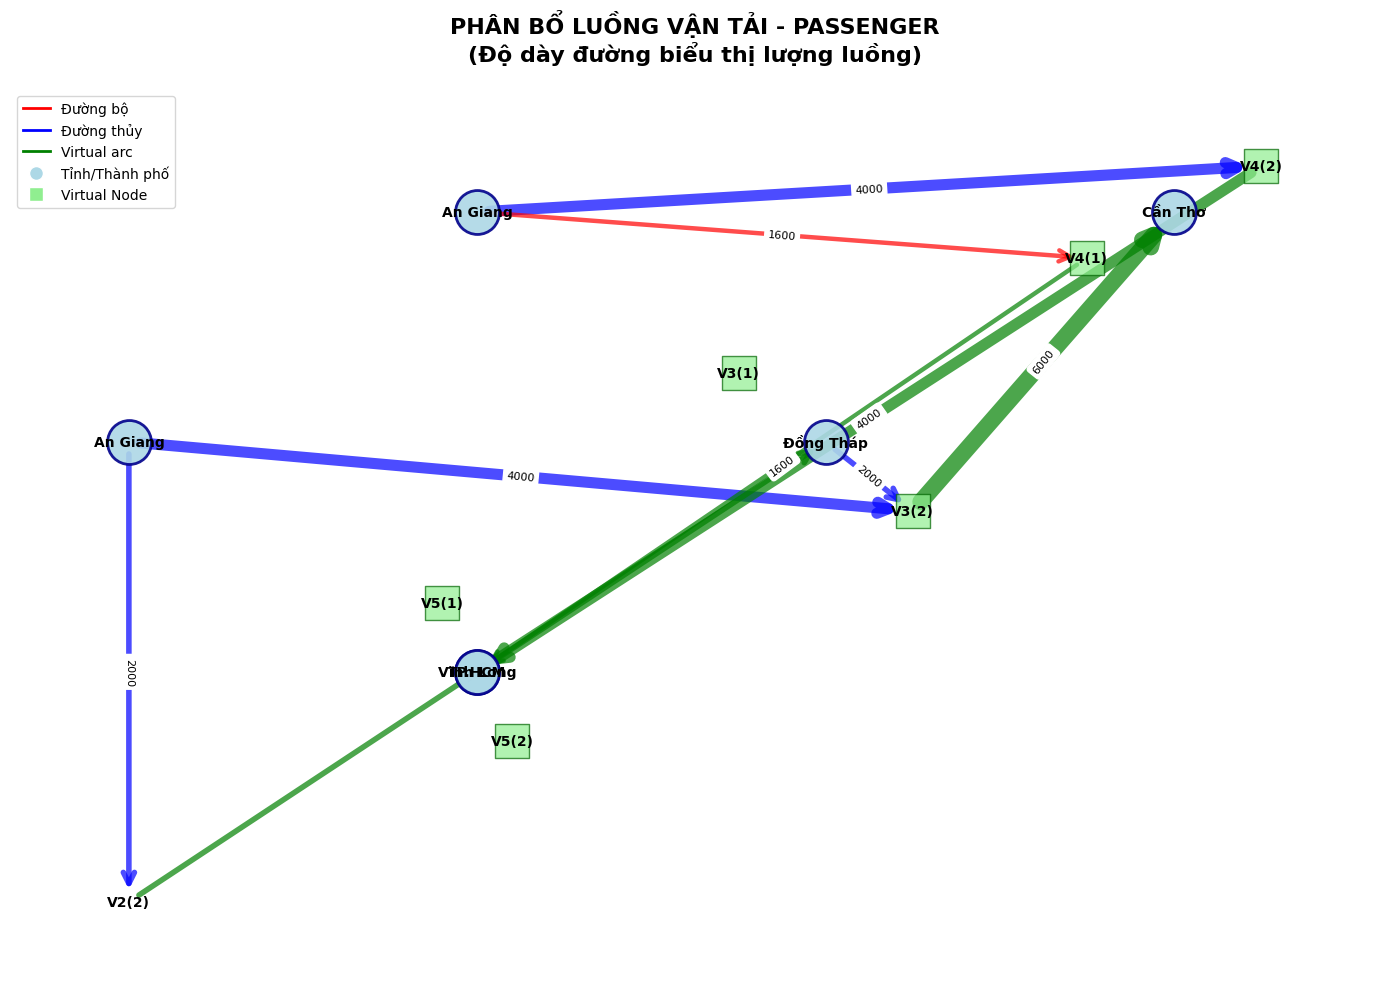


PHÂN BỔ LUỒNG CHI TIẾT - PASSENGER:

TUYẾN: An Giang → TP.HCM
Nhu cầu: 3000 đơn vị

  Giai đoạn 1:
    🛣️ Path 1: 2000 đơn vị (66.7%)
      📏 Độ dài: 23 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 3^2 → Cần Thơ
    🛣️ Path 4: 1000 đơn vị (33.3%)
      📏 Độ dài: 138 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 2^2 → Đồng Tháp → 3^2 → Cần Thơ
    📊 Tổng luồng giai đoạn 1: 3000 đơn vị
    🛣️ Số đường đi được sử dụng: 2

  Giai đoạn 2:
    🛣️ Path 8: 2000 đơn vị (66.7%)
      📏 Độ dài: 96 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 3^2 → Cần Thơ
    🛣️ Path 12: 1000 đơn vị (33.3%)
      📏 Độ dài: 134 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 2^2 → Đồng Tháp → 3^2 → Cần Thơ
    📊 Tổng luồng giai đoạn 2: 3000 đơn vị
    🛣️ Số đường đi được sử dụng: 2

TUYẾN: Đồng Tháp → Vĩnh Long
Nhu cầu: 2800 đơn vị

  Giai đoạn 1:
    🛣️ Path 1: 2000 đơn vị (71.4%)
      📏 Độ dài: 74 km
      🚛 Phương thức: ĐƯỜNG THỦY
   

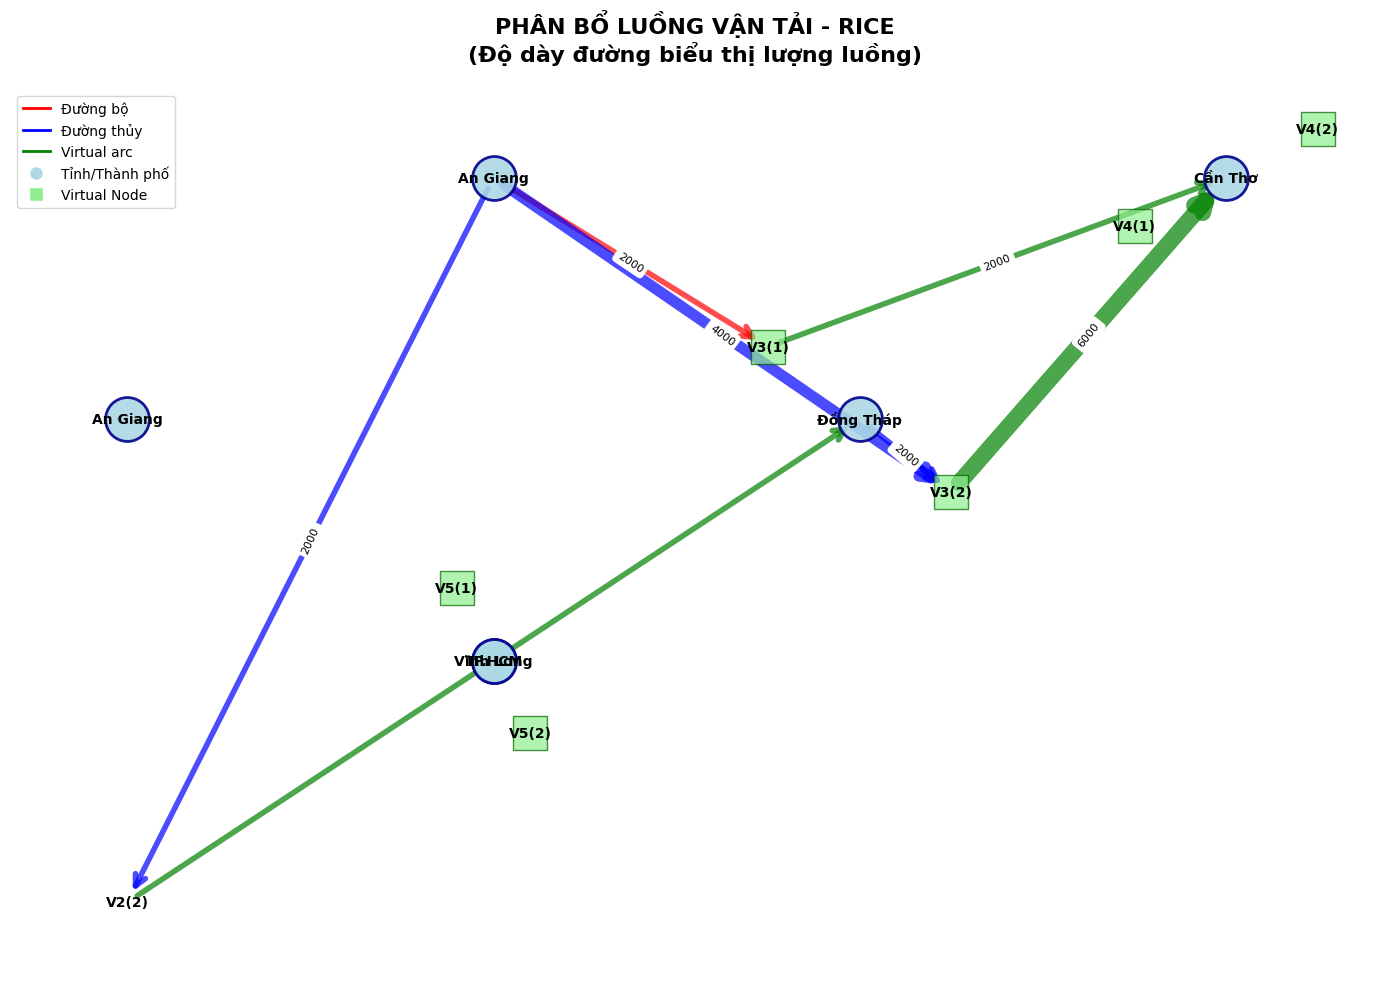


PHÂN BỔ LUỒNG CHI TIẾT - RICE:

TUYẾN: Đồng Tháp → TP.HCM
Nhu cầu: 4000 đơn vị

  Giai đoạn 1:
    🛣️ Path 2: 1000 đơn vị (25.0%)
      📏 Độ dài: 13 km
      🚛 Phương thức: ĐƯỜNG BỘ
      🗺️ Lộ trình: An Giang → 3^1 → Cần Thơ
    🛣️ Path 4: 1000 đơn vị (25.0%)
      📏 Độ dài: 178 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 2^2 → Đồng Tháp → 3^2 → Cần Thơ
    🛣️ Path 8: 2000 đơn vị (50.0%)
      📏 Độ dài: 21 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 3^2 → Cần Thơ
    📊 Tổng luồng giai đoạn 1: 4000 đơn vị
    🛣️ Số đường đi được sử dụng: 3

  Giai đoạn 2:
    🛣️ Path 1: 2000 đơn vị (50.0%)
      📏 Độ dài: 13 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 3^2 → Cần Thơ
    🛣️ Path 4: 1000 đơn vị (25.0%)
      📏 Độ dài: 178 km
      🚛 Phương thức: ĐƯỜNG THỦY
      🗺️ Lộ trình: An Giang → 2^2 → Đồng Tháp → 3^2 → Cần Thơ
    🛣️ Path 7: 1000 đơn vị (25.0%)
      📏 Độ dài: 21 km
      🚛 Phương thức: ĐƯỜNG BỘ
      🗺️ Lộ trình: An G

In [49]:
def main():
    """Hàm chính thực hiện toàn bộ quy trình"""
    
    print("BẮT ĐẦU CHƯƠNG TRÌNH TỐI ƯU MẠNG LƯỚI VẬN TẢI ĐA PHƯƠNG THỨC")
    print("=" * 60)
    
    # BƯỚC 1: Tìm đường đi cho các cặp OD
    print("\nBƯỚC 1: TÌM ĐƯỜNG ĐI CHO CÁC CẶP OD")
    print("-" * 40)
    
    n_physical, edges, OD_pairs_physical = process_input_data()
    G_exp, _ = build_expanded_graph(n_physical, edges)
    print("Đã xây dựng đồ thị mở rộng thành công")
    
    # BƯỚC 2: Xử lý dữ liệu đầu vào
    print("\nBƯỚC 2: XỬ LÝ DỮ LIỆU ĐẦU VÀO")
    print("-" * 40)
    print(f"Số nodes vật lý: {n_physical}")
    print(f"Số cung đường: {len(edges)}")
    print(f"Số cặp OD: {sum(len(od_list) for od_list in OD_pairs_physical.values())}")
    
    # BƯỚC 3: Tìm tất cả near-optimal paths
    all_paths_for_model = find_near_optimal_paths(G_exp, n_physical, OD_pairs_physical)
    
    # BƯỚC 4: Chuyển đổi và giải mô hình tối ưu
    print("\nBƯỚC 4: CHUYỂN PATH THÀNH VIRTUAL ARCS VÀ GIẢI MÔ HÌNH TỐI ƯU")
    print("-" * 60)
    
    paths_adjusted = prepare_optimization_data(all_paths_for_model)
    model, model_data = create_optimization_model(paths_adjusted)
    solved_model = solve_and_display_results(model, model_data)
    
    # Visualization
    print("\nBƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ")
    print("-" * 40)
    visualize_network_flows(model_data, solved_model)
    
    print("\n" + "=" * 60)
    print("CHƯƠNG TRÌNH ĐÃ HOÀN THÀNH!")
    print("=" * 60)

# ======== CHẠY CHƯƠNG TRÌNH ========

if __name__ == "__main__":
    main()

In [51]:
import heapq
import time
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx

# ===================================================================
# BƯỚC 1+2: XÂY ĐỒ THỊ MỞ RỘNG & TÌM NEAR-OPTIMAL PATHS
# ===================================================================

def build_expanded_graph(edges, switch_cost=2):
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length + switch_cost))
        else:  # Water
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length + switch_cost))
    return G_exp

def dijkstra_multi_target(G_exp, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for t in targets:
        dist[t] = 0
        heapq.heappush(heap, (0, t))
    while heap:
        d, node = heapq.heappop(heap)
        if d > dist[node]: continue
        for neigh, cost in G_exp[node]:
            nd = d + cost
            if nd < dist[neigh]:
                dist[neigh] = nd
                heapq.heappush(heap, (nd, neigh))
    return dist

def find_near_optimal_paths(G_exp, s, t, epsilon=0.5, switch_cost=2, max_paths=100):
    dprime = dijkstra_multi_target(G_exp, [(t,1), (t,2)])
    Lmin = min(dprime.get((s,1), float('inf')), dprime.get((s,2), float('inf')))
    if Lmin == float('inf'): return []
    bound = (1 + epsilon) * Lmin
    results = []
    n_physical = max(u for u,_ in G_exp.keys()) + 1

    for start_mode in [1, 2]:
        visited = [False] * n_physical
        visited[s] = True
        stack = [((s, start_mode), 0, [(s, start_mode)])]

        while stack and len(results) < max_paths:
            node, cost, path = stack.pop()
            u, mode = node
            if u == t:
                results.append((path, cost))
                continue
            for neigh, w in sorted(G_exp[node], key=lambda x: x[1]):
                v, _ = neigh
                if visited[v]: continue
                new_cost = cost + w
                if new_cost + dprime.get(neigh, float('inf')) > bound: continue
                new_path = path + [neigh]
                new_visited = visited[:]
                new_visited[v] = True
                stack.append((neigh, new_cost, new_path))
    return results

# ===================================================================
# BƯỚC 3: DỮ LIỆU TOY EXAMPLE
# ===================================================================

def load_toy_data():
    edges = [
        (1,3,1,5), (1,3,2,3),   # An Giang → Cần Thơ
        (2,3,1,4), (2,3,2,2),   # Đồng Tháp → Cần Thơ
        (3,4,1,6), (3,4,2,3),   # Cần Thơ → HCM
        (3,5,1,5), (3,5,2,2),   # Cần Thơ → Vĩnh Long
        (1,4,1,7), (1,4,2,4),   # An Giang → HCM (direct)
    ]
    OD = {'passenger': [(1,4), (2,5)], 'rice': [(2,4)]}
    demand = {('passenger',(1,4)):1000, ('passenger',(2,5)):800, ('rice',(2,4)):2000}
    return edges, OD, demand

# ===================================================================
# BƯỚC 4: TẠO TẤT CẢ NEAR-OPTIMAL PATHS
# ===================================================================

edges, OD_pairs, demands = load_toy_data()
G_exp = build_expanded_graph(edges, switch_cost=2)
all_paths = {}

print("TÌM NEAR-OPTIMAL PATHS")
print("="*60)
for g, pairs in OD_pairs.items():
    all_paths[g] = {}
    for s,t in pairs:
        paths = find_near_optimal_paths(G_exp, s, t, epsilon=0.5)
        all_paths[g][(s,t)] = paths
        print(f"{g}: {s}→{t} → {len(paths)} paths")

# ===================================================================
# BƯỚC 5: GIẢI MASTER PROBLEM VỚI GUROBI (PATH-BASED)
# ===================================================================

def solve_with_gurobi():
    model = gp.Model("Mekong_MultiPeriod_MultiModal")
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300

    T = [1,2]
    H = [3]
    potential_hubs = [3]
    potential_arcs = [(3,4,1), (3,4,2)]  # (u,v,mode)

    # --- Biến ---
    y_h = model.addVars(potential_hubs, [0,1], T, vtype=GRB.BINARY, name="y_hub")
    y_a = model.addVars(potential_arcs, [0,1], T, vtype=GRB.BINARY, name="y_arc")
    v_p = {}   # flow fraction on path
    cost_p = {}  # cost of path * demand

    path_idx = 0
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            dem = demands[(g,(o,d))]
            for path_nodes, path_cost in paths:
                var = model.addVar(lb=0, ub=1, name=f"v_{g}_{o}_{d}_{path_idx}")
                v_p[(g,o,d,path_idx)] = var
                cost_p[(g,o,d,path_idx)] = path_cost * dem
                path_idx += 1

    u_h = model.addVars(H, T, lb=0, name="u_hub")
    model.update()

    # --- Hàm mục tiêu ---
    invest_hub = gp.quicksum(1000 * (2000 if l==0 else 7000) * y_h[h,l,t]
                             for h in potential_hubs for l in [0,1] for t in T)
    invest_arc = gp.quicksum(800 * 3000 * y_a[3,4,1,l,t] + 500 * 4000 * y_a[3,4,2,l,t]
                             for l in [0,1] for t in T)
    service = gp.quicksum(1 * u_h[h,t] for h in H for t in T)
    transport = gp.quicksum(cost_p[k] * v_p[k] for k in v_p)

    model.setObjective(invest_hub + invest_arc + service + transport, GRB.MINIMIZE)

    # --- Ràng buộc ---
    # 1. Phân bổ luồng = 1
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            for t in T:
                model.addConstr(
                    gp.quicksum(v_p[(g,o,d,idx)] for idx in range(len(paths))) == 1,
                    name=f"flow_{g}_{o}_{d}_{t}"
                )

    # 2. Luồng qua hub
    for h in H:
        for t in T:
            flow = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o,dest), paths in od_dict.items():
                    dem = demands[(g,(o,dest))]
                    for idx, (path, _) in enumerate(paths):
                        if any(node[0] == h for node in path):
                            flow += dem * v_p[(g,o,dest,idx)]
            model.addConstr(u_h[h,t] == flow)

    # 3. Dung lượng hub
    for h in potential_hubs:
        for t in T:
            model.addConstr(u_h[h,t] <= gp.quicksum((2000 if l==0 else 7000) * y_h[h,l,t] for l in [0,1]))

    # 4. Dung lượng arc
    for (u,v,m) in potential_arcs:
        for t in T:
            flow_arc = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o,d), paths in od_dict.items():
                    dem = demands[(g,(o,d))]
                    for idx, (path,_) in enumerate(paths):
                        for i in range(len(path)-1):
                            if path[i] == (u,m) and path[i+1][0] == v:
                                flow_arc += dem * v_p[(g,o,d,idx)]
            cap = 3000 if m==1 else 4000
            model.addConstr(flow_arc <= cap * gp.quicksum(y_a[u,v,m,l,t] for l in [0,1]))

    # 5. Logic chọn mức
    for h in potential_hubs:
        for t in T:
            model.addConstr(gp.quicksum(y_h[h,l,t] for l in [0,1]) == 1)
    for (u,v,m) in potential_arcs:
        for t in T:
            model.addConstr(gp.quicksum(y_a[u,v,m,l,t] for l in [0,1]) == 1)

    # 6. Không giảm dung lượng
    for h in potential_hubs:
        for ti in range(len(T)-1):
            t1, t2 = T[ti], T[ti+1]
            model.addConstr(
                gp.quicksum((2000 if l==0 else 7000) * y_h[h,l,t2] for l in [0,1]) >=
                gp.quicksum((2000 if l==0 else 7000) * y_h[h,l,t1] for l in [0,1])
            )

    # Giải
    model.optimize()

    if model.Status == GRB.OPTIMAL:
        print(f"\nTỔNG CHI PHÍ TỐI ƯU: {model.ObjVal:,.0f}")
        print("\nNÂNG CẤP HUB:")
        for h in potential_hubs:
            for t in T:
                for l in [0,1]:
                    if y_h[h,l,t].X > 0.5:
                        print(f"  Hub {h} kỳ {t}: mức {l} → dung lượng {2000 if l==0 else 7000}")

        print("\nNÂNG CẤP ARC:")
        for (u,v,m) in potential_arcs:
            for t in T:
                for l in [0,1]:
                    if y_a[u,v,m,l,t].X > 0.5:
                        mode = "Đường bộ" if m==1 else "Đường thủy"
                        print(f"  {u}→{v} ({mode}) kỳ {t}: mức {l}")

        print("\nPHÂN BỔ LUỒNG:")
        for g, od_dict in all_paths.items():
            for (o,d), paths in od_dict.items():
                print(f"\n{g.upper()}: {o}→{d}")
                for t in T:
                    used = []
                    for idx, (path,_) in enumerate(paths):
                        key = (g,o,d,idx)
                        if v_p[key].X > 0.01:
                            flow = demands[(g,(o,d))] * v_p[key].X
                            route = "→".join([f"{n[0]}[{ 'R' if n[1]==1 else 'W' }]" for n in path])
                            used.append(f"Path {idx}: {flow:,.0f} | {route}")
                    if used: print(f"  Kỳ {t}:")
                    for u in used: print(f"    {u}")

solve_with_gurobi()

ModuleNotFoundError: No module named 'gurobipy'

In [ ]:
import heapq
import time
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt

# ===================================================================
# BƯỚC 1+2: XÂY ĐỒ THỊ MỞ RỘNG & TÌM NEAR-OPTIMAL PATHS
# ===================================================================

def build_expanded_graph(edges, switch_cost=2):
    G_exp = defaultdict(list)
    for u, v, mode, length in edges:
        if mode == 1:  # Road
            G_exp[(u, 1)].append(((v, 1), length))
            G_exp[(u, 1)].append(((v, 2), length + switch_cost))
        else:  # Water
            G_exp[(u, 2)].append(((v, 2), length))
            G_exp[(u, 2)].append(((v, 1), length + switch_cost))
    return G_exp

def dijkstra_multi_target(G_exp, targets):
    dist = defaultdict(lambda: float('inf'))
    heap = []
    for t in targets:
        dist[t] = 0
        heapq.heappush(heap, (0, t))
    while heap:
        d, node = heapq.heappop(heap)
        if d > dist[node]: continue
        for neigh, cost in G_exp[node]:
            nd = d + cost
            if nd < dist[neigh]:
                dist[neigh] = nd
                heapq.heappush(heap, (nd, neigh))
    return dist

def find_near_optimal_paths(G_exp, s, t, epsilon=0.5, switch_cost=2, max_paths=100):
    dprime = dijkstra_multi_target(G_exp, [(t,1), (t,2)])
    Lmin = min(dprime.get((s,1), float('inf')), dprime.get((s,2), float('inf')))
    if Lmin == float('inf'): return []
    bound = (1 + epsilon) * Lmin
    results = []
    n_physical = max(u for u,_ in G_exp.keys()) + 1

    for start_mode in [1, 2]:
        visited = [False] * n_physical
        visited[s] = True
        stack = [((s, start_mode), 0, [(s, start_mode)])]

        while stack and len(results) < max_paths:
            node, cost, path = stack.pop()
            u, mode = node
            if u == t:
                results.append((path, cost))
                continue
            for neigh, w in sorted(G_exp[node], key=lambda x: x[1]):
                v, _ = neigh
                if visited[v]: continue
                new_cost = cost + w
                if new_cost + dprime.get(neigh, float('inf')) > bound: continue
                new_path = path + [neigh]
                new_visited = visited[:]
                new_visited[v] = True
                stack.append((neigh, new_cost, new_path))
    return results

# ===================================================================
# BƯỚC 3: DỮ LIỆU TOY EXAMPLE
# ===================================================================

def load_toy_data():
    edges = [
        (1,3,1,5), (1,3,2,3),   # An Giang → Cần Thơ
        (2,3,1,4), (2,3,2,2),   # Đồng Tháp → Cần Thơ
        (3,4,1,6), (3,4,2,3),   # Cần Thơ → HCM
        (3,5,1,5), (3,5,2,2),   # Cần Thơ → Vĩnh Long
        (1,4,1,7), (1,4,2,4),   # An Giang → HCM (direct)
    ]
    OD = {'passenger': [(1,4), (2,5)], 'rice': [(2,4)]}
    demand = {('passenger',(1,4)):1000, ('passenger',(2,5)):800, ('rice',(2,4)):2000}
    return edges, OD, demand

# ===================================================================
# BƯỚC 4: TẠO TẤT CẢ NEAR-OPTIMAL PATHS
# ===================================================================

edges, OD_pairs, demands = load_toy_data()
G_exp = build_expanded_graph(edges, switch_cost=2)
all_paths = {}

print("TÌM NEAR-OPTIMAL PATHS")
print("="*60)
for g, pairs in OD_pairs.items():
    all_paths[g] = {}
    for s,t in pairs:
        paths = find_near_optimal_paths(G_exp, s, t, epsilon=0.5)
        all_paths[g][(s,t)] = paths
        print(f"{g}: {s}→{t} → {len(paths)} paths")

# ===================================================================
# BƯỚC 5: GIẢI MASTER PROBLEM VỚI GUROBI (PATH-BASED)
# ===================================================================

def solve_with_gurobi():
    model = gp.Model("Mekong_MultiPeriod_MultiModal")
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300

    T = [1,2]
    H = [3]
    potential_hubs = [3]
    potential_arcs = [(3,4,1), (3,4,2)]  # (u,v,mode)

    # --- Biến ---
    y_h = model.addVars(potential_hubs, [0,1], T, vtype=GRB.BINARY, name="y_hub")
    y_a = model.addVars(potential_arcs, [0,1], T, vtype=GRB.BINARY, name="y_arc")
    v_p = {}   # flow fraction on path
    cost_p = {}  # cost of path * demand

    path_idx = 0
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            dem = demands[(g,(o,d))]
            for path_nodes, path_cost in paths:
                var = model.addVar(lb=0, ub=1, name=f"v_{g}_{o}_{d}_{path_idx}")
                v_p[(g,o,d,path_idx)] = var
                cost_p[(g,o,d,path_idx)] = path_cost * dem
                path_idx += 1

    u_h = model.addVars(H, T, lb=0, name="u_hub")
    model.update()

    # --- Hàm mục tiêu ---
    invest_hub = gp.quicksum(1000 * (2000 if l==0 else 7000) * y_h[h,l,t]
                             for h in potential_hubs for l in [0,1] for t in T)
    invest_arc = gp.quicksum(800 * 3000 * y_a[3,4,1,l,t] + 500 * 4000 * y_a[3,4,2,l,t]
                             for l in [0,1] for t in T)
    service = gp.quicksum(1 * u_h[h,t] for h in H for t in T)
    transport = gp.quicksum(cost_p[k] * v_p[k] for k in v_p)

    model.setObjective(invest_hub + invest_arc + service + transport, GRB.MINIMIZE)

    # --- Ràng buộc ---
    # 1. Phân bổ luồng = 1
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            for t in T:
                model.addConstr(
                    gp.quicksum(v_p[(g,o,d,idx)] for idx in range(len(paths))) == 1,
                    name=f"flow_{g}_{o}_{d}_{t}"
                )

    # 2. Luồng qua hub
    for h in H:
        for t in T:
            flow = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o,dest), paths in od_dict.items():
                    dem = demands[(g,(o,dest))]
                    for idx, (path, _) in enumerate(paths):
                        if any(node[0] == h for node in path):
                            flow += dem * v_p[(g,o,dest,idx)]
            model.addConstr(u_h[h,t] == flow)

    # 3. Dung lượng hub
    for h in potential_hubs:
        for t in T:
            model.addConstr(u_h[h,t] <= gp.quicksum((2000 if l==0 else 7000) * y_h[h,l,t] for l in [0,1]))

    # 4. Dung lượng arc
    for (u,v,m) in potential_arcs:
        for t in T:
            flow_arc = gp.LinExpr()
            for g, od_dict in all_paths.items():
                for (o,d), paths in od_dict.items():
                    dem = demands[(g,(o,d))]
                    for idx, (path,_) in enumerate(paths):
                        for i in range(len(path)-1):
                            if path[i] == (u,m) and path[i+1][0] == v:
                                flow_arc += dem * v_p[(g,o,d,idx)]
            cap = 3000 if m==1 else 4000
            model.addConstr(flow_arc <= cap * gp.quicksum(y_a[u,v,m,l,t] for l in [0,1]))

    # 5. Logic chọn mức
    for h in potential_hubs:
        for t in T:
            model.addConstr(gp.quicksum(y_h[h,l,t] for l in [0,1]) == 1)
    for (u,v,m) in potential_arcs:
        for t in T:
            model.addConstr(gp.quicksum(y_a[u,v,m,l,t] for l in [0,1]) == 1)

    # 6. Không giảm dung lượng
    for h in potential_hubs:
        for ti in range(len(T)-1):
            t1, t2 = T[ti], T[ti+1]
            model.addConstr(
                gp.quicksum((2000 if l==0 else 7000) * y_h[h,l,t2] for l in [0,1]) >=
                gp.quicksum((2000 if l==0 else 7000) * y_h[h,l,t1] for l in [0,1])
            )

    # Giải
    model.optimize()

    if model.Status != GRB.OPTIMAL:
        print("KHÔNG TÌM ĐƯỢC NGHIỆM TỐI ƯU")
        return

    # ===================================================================
    # IN KẾT QUẢ THEO ĐỊNH DẠNG FILE MẪU
    # ===================================================================

    print("\n" + "="*70)
    print(" " * 20 + "TOY EXAMPLE - KẾT QUẢ TỐI ƯU")
    print("="*70)

    print(f"\nTỔNG CHI PHÍ TỐI ƯU: {model.ObjVal:,.0f}")

    # --- 1. Network Description ---
    print("\n1. NETWORK DESCRIPTION")
    print("-" * 50)
    print("• Time Periods: T = {1, 2}, each spanning 5 years.")
    print("• Nodes: V = {1, 2, 3, 4, 5}, representing An Giang (1), Đồng Tháp (2), Cần Thơ (3), Hồ Chí Minh City (4), Vĩnh Long (5).")
    print("• Hubs: H = {3} (Cần Thơ), with initial open hub H0 = {3}")
    print("• Arcs: A = {(1,3), (1,4), (2,3), (3,4), (3,5)}")
    print("• Commodities: G = {rice, passengers}")
    print("• OD pairs K:")
    print("   - Passengers: k1 = (1,4), k2 = (2,5)")
    print("   - Rice: k3 = (2,4)")
    print("• L = {0,1}")
    print("• c = {0,1}")

    # --- 2. Parameters ---
    print("\n2. PARAMETERS")
    print("-" * 50)
    print("Hub Costs")
    print("• f_h,1 = 1000 (cost to expand Cần Thơ hub to level 1 in both periods).")
    print("• Δ_h,1 = 5000 (capacity of Cần Thơ hub when expanded).")
    print("\nArc Costs")
    print("• f_(3,4,1) = 800 (upgrade cost for arc (3,4) by road).")
    print("• f_(3,4,2) = 500 (upgrade cost for arc (3,4) by waterway).")
    print("• Δ_(3,4,1) = 3000, Δ_(3,4,2) = 4000 (capacity of arc after upgrade).")
    print("\nTransportation Costs")
    print("• c_(1,3,1) = 5, c_(1,3,2) = 3 (unit transportation cost on arc (1,3)).")
    print("• c_(2,3,1) = 4, c_(2,3,2) = 2")
    print("• c_(3,4,1) = 6, c_(3,4,2) = 3")
    print("• c_(3,5,1) = 5, c_(3,5,2) = 2")
    print("• c_(1,4,1) = 7, c_(1,4,2) = 4")
    print("\nMode-Switching Cost")
    print("• c' = 2 (cost of switching modes at the hub).")
    print("\nService Cost at Hub")
    print("• c_h = 1 (service handling cost at Cần Thơ hub).")
    print("\nDemand")
    print("• w_(1,4,1) = 1000 (passengers from node 1 to 4).")
    print("• w_(2,5,1) = 800 (passengers from node 2 to 5).")
    print("• w_(2,4,1) = 2000 (rice from node 2 to 4).")

    # --- 3. Upgrade Timeline ---
    print("\n3. DETAILED UPGRADE TIMELINE")
    print("-" * 50)
    upgraded_hubs = []
    upgraded_arcs = []
    for h in potential_hubs:
        for t in T:
            for l in [0,1]:
                if y_h[h,l,t].X > 0.5:
                    upgraded_hubs.append(f"Hub {h} upgraded in period {t}")
    for (u,v,m) in potential_arcs:
        for t in T:
            for l in [0,1]:
                if y_a[u,v,m,l,t].X > 0.5:
                    mode = "road" if m == 1 else "waterway"
                    upgraded_arcs.append(f"Arc {u}→{v} ({mode}) upgraded in period {t}")

    if not upgraded_hubs and not upgraded_arcs:
        print("• No upgrades in any period.")
    else:
        for item in upgraded_hubs + upgraded_arcs:
            print(f"• {item}")

    # --- 4. Flow Allocation ---
    print("\n4. FLOW ALLOCATION")
    print("-" * 50)
    for g, od_dict in all_paths.items():
        for (o,d), paths in od_dict.items():
            print(f"\n{g.upper()}: {o}→{d}")
            for t in T:
                used = []
                total_flow = 0
                for idx, (path,_) in enumerate(paths):
                    key = (g,o,d,idx)
                    if v_p[key].X > 0.01:
                        flow = demands[(g,(o,d))] * v_p[key].X
                        total_flow += flow
                        route = " → ".join([f"{n[0]}[{ 'R' if n[1]==1 else 'W' }]" for n in path])
                        used.append(f"   Path {idx}: {flow:,.0f} units | Route: {route}")
                if used:
                    print(f"  Period {t}: Total = {total_flow:,.0f}")
                    for u in used:
                        print(u)
                else:
                    print(f"  Period {t}: No flow")

    # --- 5. Objective Breakdown ---
    print("\n5. OBJECTIVE FUNCTION BREAKDOWN")
    print("-" * 50)
    hub_cost = sum(1000 * (2000 if l==0 else 7000) * y_h[h,l,t].X
                   for h in potential_hubs for l in [0,1] for t in T)
    arc_cost = sum(800 * 3000 * y_a[3,4,1,l,t].X + 500 * 4000 * y_a[3,4,2,l,t].X
                   for l in [0,1] for t in T)
    service_cost = sum(u_h[h,t].X for h in H for t in T)
    transport_cost = sum(cost_p[k] * v_p[k].X for k in v_p)

    print(f"• Hub investment cost: {hub_cost:,.0f}")
    print(f"• Arc investment cost: {arc_cost:,.0f}")
    print(f"• Hub service cost: {service_cost:,.0f}")
    print(f"• Transportation cost: {transport_cost:,.0f}")
    print(f"• TOTAL: {model.ObjVal:,.0f}")

    print("\n" + "="*70)
    print(" " * 25 + "HOÀN TẤT TỐI ƯU")
    print("="*70)

# Chạy
solve_with_gurobi()